<a href="https://colab.research.google.com/github/MahyarGarshasbi/TLP-R2S-ATMS/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="crimson">Incremental Learning for Passive Microwave Precipitation Retrievals using Advanced Technology Microwave Sounder</font>

<font color="royalblue">**Mahyar Garshasbi, Buddha Subedi, and Ardeshir Ebtehaj**</font>

Saint Anthony Falls Laboratory, Department of Civil, Environmental, and Geo-Engineering,

University of Minnesota

---

This notebook demonstrates **TLP-R2S** (Transfer Learning of global Precipitation from Reanalysis data to Satellite observations), a two-stage incremental learning framework for passive microwave precipitation retrieval from ATMS observations. The algorithm trains XGBoost models through:

- **Stage I:** Pre-training on ERA5 reanalysis labels for precipitation phase and rate  
- **Stage II:** Fine-tuning with DPR rainfall and CPR snowfall satellite observations

The approach enables full-swath ATMS retrieval while resolving bimodal artifacts in rainfall distributions and mitigating systematic high-latitude snowfall biases present in current GPM products.

<p align="center">
  <img src="https://raw.githubusercontent.com/MahyarGarshasbi/TLP-R2S-ATMS/main/Figures/Fig05.png" width="550">
</p>


### Notebook Contents
1. **Demo Training Code** — Lightweight XGBoost models with sample data  
2. **Orbital Retrieval Example** — Full ATMS swath precipitation retrieval

---


# <font color="darkgreen">⚙️ Setup & Data Download</font>

---

### 📦 Dependencies
Install required packages for data handling and visualization.

### 📂 Sample Data
Download lightweight training datasets and orbital retrieval files from Google Drive:

| File | Description |
|:-----|:------------|
| `ERA5_LABEL.npy` | ERA5 precipitation labels (ATMS TBs + ancillary) |
| `Satellite_CLASS.npy` | DPR/CPR phase labels |
| `final_DPR.npy` | DPR rainfall coincidences |
| `final_CPR.npy` | CPR snowfall coincidences |
| `Orbit_*.npy` | Sample ATMS orbit for retrieval demo |

---

In [ ]:
!pip install gdown -q

import gdown
import numpy as np
import os

# Download entire folder
folder_url = "https://drive.google.com/drive/folders/1d4THTCVH_K2wbYCQiZB34Sf-jdKQprLj?usp=sharing"
gdown.download_folder(folder_url, quiet=False, use_cookies=False)
!pip install cartopy

Retrieving folder contents


Retrieving folder 1YkuToWWUZGDHAeHk2k17cJS1sv3DAVdK Data
Processing file 1UOLNmNN6q5kxzhSFHbN4D22RRbHECgr6 CPR.npy
Processing file 1uoR61TAqd7HlC09prwjJju8H7CMlAnsQ DPR.npy
Processing file 1c2AwZStJYZrP2BqCTaLs0q94IF3tjZh0 ERA5_LABEL.npy
Processing file 1acPb10_ds8JZWIBQSS2Vv9lIMzZQwdTG Satellite_CLASS.npy
Retrieving folder 1yA8pyJN-IKBtMLfUPumZlRqBxhoyEUw_ Orbits
Processing file 1gwk3w49NJhL6h18UJ2eWrMtH-puAIygP 1C.NPP.ATMS.XCAL2019-V.20230131-S043214-E061343.058350.V07A.ERA5.HDF5
Processing file 1g36ySOtBOAYq30lh782GHOGU436hiYAe 1C.NPP.ATMS.XCAL2019-V.20230216-S180414-E194543.058585.V07A.ERA5.HDF5
Processing file 1I_qyg7CqtsxB7ONM9J-ZxEQ-Mp8Ah92c 1C.NPP.ATMS.XCAL2019-V.20230315-S060744-E074913.058961.V07A.ERA5.HDF5
Processing file 1dE15UH6P_doeoqr-CZJJZbRY7QwTdxwW 2A-1C.GPM-NPP.DPR-ATMS.COIN2024.20230131-S053007-E053750.050708-058350.V07A.ERA5.HDF5
Processing file 1Jvx-HixoYlJEp7DwQ4VyVS4OclX8BX4m 2A-1C.GPM-NPP.DPR-ATMS.COIN2024.20230315-S072715-E073707.051378-058961.V07A.ERA5.HDF5
P

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1UOLNmNN6q5kxzhSFHbN4D22RRbHECgr6
From (redirected): https://drive.google.com/uc?id=1UOLNmNN6q5kxzhSFHbN4D22RRbHECgr6&confirm=t&uuid=a64600fc-60ed-4034-98b0-9f2a36c1633f
To: /content/Implementation_1/Data/CPR.npy
100%|██████████| 2.42G/2.42G [00:25<00:00, 94.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1uoR61TAqd7HlC09prwjJju8H7CMlAnsQ
From (redirected): https://drive.google.com/uc?id=1uoR61TAqd7HlC09prwjJju8H7CMlAnsQ&confirm=t&uuid=17467253-0634-4d22-801f-583df6957bd0
To: /content/Implementation_1/Data/DPR.npy
100%|██████████| 1.10G/1.10G [00:08<00:00, 130MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1c2AwZStJYZrP2BqCTaLs0q94IF3tjZh0
From (redirected): https://drive.google.com/uc?id=1c2AwZStJYZrP2BqCTaLs0q94IF3tjZh0&confirm=t&uuid=f891b8d1-a2af-4f97-810c-3672ae2dd679
To: /

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 37.0 MB/s eta 0:00:00


<h1 align="left"><font color="darkorange">Model Training</font></h1>

---

<h3 align="left">Two-Stage Incremental Learning Pipeline</h3>

<p align="left">Train three XGBoost models through sequential knowledge transfer:</p>

<div align="left">

| Model | Task | Stage I (ERA5) | Stage II (Satellite) |
|:-----:|:----:|:--------------:|:--------------------:|
| `CLASS.model` | Phase Classification | ERA5 labels | DPR + CPR |
| `RAIN.model` | Rainfall Regression | ERA5 rain rates | DPR |
| `SNOW.model` | Snowfall Regression | ERA5 snow rates | CPR |

</div>

<p align="left">⚠️ <b>Note:</b> This demo uses lightweight data and reduced boosting rounds for fast execution.<br>Full training parameters are detailed in the manuscript.</p>

---

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(42)


def preprocess_data(data):
    data[:, 27:30] *= 1000
    data[data[:, 43] < -30000, 43] = np.nan
    data[data[:, 37] < 0, 37] = np.nan
    return data


def add_phase_labels(arr, rain_threshold=0.01, snow_threshold=0.005):
    result = np.zeros((arr.shape[0], arr.shape[1] + 1))
    result[:, :-1] = arr

    rain_rate = (arr[:, -2] - arr[:, -1]) * 3600
    snow_rate = arr[:, -1] * 3600

    result[(rain_rate > rain_threshold) & (snow_rate < snow_threshold), -1] = 1
    result[(rain_rate < rain_threshold) & (snow_rate > snow_threshold), -1] = 2
    result[(rain_rate > rain_threshold) & (snow_rate > snow_threshold), -1] = 3

    return result


# =============================================================================
#                           PHASE CLASSIFICATION
# =============================================================================
print("=" * 80)
print("PHASE CLASSIFICATION".center(80))
print("=" * 80)

# -----------------------------------------------------------------------------
# Stage 1: Training on ERA5 Labels
# -----------------------------------------------------------------------------
print("\n[Stage 1] Training on ERA5 Labels...")

data = add_phase_labels(preprocess_data(np.load('Implementation_1/Data/ERA5_LABEL.npy')))
data = np.delete(data[data[:, -1] != 3], [-2, -3], axis=1)
data = data[np.random.permutation(data.shape[0])]

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=42)
del data

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
del X_train, X_test, y_train, y_test

xgb.train(
    {'objective': 'multi:softmax', 'num_class': 3, 'learning_rate': 0.640808, 'max_depth': 14, 'subsample': 0.5,
     'reg_alpha': 0.095, 'reg_lambda': 5.843, 'gamma': 0.661776, 'num_parallel_tree': 3, 'eval_metric': 'merror'},
    dtrain, num_boost_round=25, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=True
).save_model('ERA5_Class.model')
del dtrain, dtest
print("[Stage 1] Model saved: ERA5_Class.model")

# -----------------------------------------------------------------------------
# Stage 2: Transfer Learning with Satellite Labels
# -----------------------------------------------------------------------------
print("\n[Stage 2] Transfer Learning with Satellite Labels...")

data = preprocess_data(np.load('Implementation_1/Data/Satellite_CLASS.npy'))[:, :-1]
data = data[data[:, 0] >= -1]
data = data[np.random.permutation(data.shape[0])]

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=42)
del data

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
del X_train, X_test, y_train, y_test

booster = xgb.Booster()
booster.load_model('ERA5_Class.model')
xgb.train(
    {'objective': 'multi:softmax', 'num_class': 3, 'learning_rate': 0.06, 'eval_metric': 'merror', 'max_depth': 15},
    dtrain, num_boost_round=25, evals=[(dtrain, 'train'), (dtest, 'test')], xgb_model=booster, verbose_eval=True
).save_model('CLASS.model')
del dtrain, dtest, booster
print("[Stage 2] Model saved: CLASS.model")


# =============================================================================
#                            RAIN REGRESSION
# =============================================================================
print("\n" + "=" * 80)
print("RAIN REGRESSION".center(80))
print("=" * 80)

# -----------------------------------------------------------------------------
# Stage 1: Training on ERA5 Labels
# -----------------------------------------------------------------------------
print("\n[Stage 1] Training on ERA5 Labels...")

data = add_phase_labels(preprocess_data(np.load('Implementation_1/Data/ERA5_LABEL.npy')))
data = data[data[:, -1] == 1]
rain_rate = (data[:, -3] - data[:, -2]) * 3600
data = np.delete(data, [-1, -2, -3], axis=1)
shuffled_idx = np.random.permutation(data.shape[0])
data, rain_rate = data[shuffled_idx], rain_rate[shuffled_idx]
del shuffled_idx

X_train, X_test, y_train, y_test = train_test_split(data, rain_rate, test_size=0.2, random_state=42)
del data, rain_rate

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
del X_train, X_test, y_train, y_test

xgb.train(
    {'objective': 'reg:squarederror', 'seed': 42, 'learning_rate': 0.076, 'max_depth': 15,
     'reg_alpha': 4.637, 'reg_lambda': 0.78, 'num_parallel_tree': 3, 'eval_metric': 'rmse'},
    dtrain, num_boost_round=50, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=True
).save_model('Rain_ERA5_Reg.model')
del dtrain, dtest
print("[Stage 1] Model saved: Rain_ERA5_Reg.model")

# -----------------------------------------------------------------------------
# Stage 2: Transfer Learning with DPR Labels
# -----------------------------------------------------------------------------
print("\n[Stage 2] Transfer Learning with DPR Labels...")

data = np.load('Implementation_1/Data/DPR.npy')
data = preprocess_data(data[(data[:, -2] == 1) & (data[:, -1] > 0)])

X_train, X_test, y_train, y_test = train_test_split(data[:, :-2], data[:, -1], test_size=0.2, random_state=42)
del data

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
del X_train, X_test, y_train, y_test

booster = xgb.Booster()
booster.load_model("Rain_ERA5_Reg.model")
xgb.train(
    {'objective': 'reg:squarederror', 'learning_rate': 0.025, 'eval_metric': 'rmse', 'max_depth': 15},
    dtrain, num_boost_round=50, evals=[(dtrain, 'train'), (dtest, 'test')], xgb_model=booster, verbose_eval=True
).save_model("RAIN.model")
del dtrain, dtest, booster
print("[Stage 2] Model saved: RAIN.model")


# =============================================================================
#                            SNOW REGRESSION
# =============================================================================
print("\n" + "=" * 80)
print("SNOW REGRESSION".center(80))
print("=" * 80)

# -----------------------------------------------------------------------------
# Stage 1: Training on ERA5 Labels
# -----------------------------------------------------------------------------
print("\n[Stage 1] Training on ERA5 Labels...")

data = add_phase_labels(preprocess_data(np.load('Implementation_1/Data/ERA5_LABEL.npy')))
data = data[data[:, -1] == 2]
snow_rate = data[:, -2] * 3600
data = np.delete(data, [-1, -2, -3], axis=1)
shuffled_idx = np.random.permutation(data.shape[0])
data, snow_rate = data[shuffled_idx], snow_rate[shuffled_idx]
del shuffled_idx

X_train, X_test, y_train, y_test = train_test_split(data, snow_rate, test_size=0.2, random_state=42)
del data, snow_rate

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
del X_train, X_test, y_train, y_test

xgb.train(
    {'objective': 'reg:squarederror', 'seed': 42, 'learning_rate': 0.096, 'max_depth': 15,
     'reg_alpha': 1.637, 'reg_lambda': 2.78, 'num_parallel_tree': 3, 'eval_metric': 'rmse'},
    dtrain, num_boost_round=50, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=True
).save_model('Snow_ERA5_Reg.model')
del dtrain, dtest
print("[Stage 1] Model saved: Snow_ERA5_Reg.model")

# -----------------------------------------------------------------------------
# Stage 2: Transfer Learning with CPR Labels
# -----------------------------------------------------------------------------
print("\n[Stage 2] Transfer Learning with CPR Labels...")

data = np.load('Implementation_1/Data/CPR.npy')
data = preprocess_data(data[(data[:, -2] == 5) & (data[:, -1] > 0)])

X_train, X_test, y_train, y_test = train_test_split(data[:, :-2], data[:, -1], test_size=0.2, random_state=42)
del data

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
del X_train, X_test, y_train, y_test

booster = xgb.Booster()
booster.load_model("Snow_ERA5_Reg.model")
xgb.train(
    {'objective': 'reg:squarederror', 'learning_rate': 0.024, 'eval_metric': 'rmse', 'max_depth': 15},
    dtrain, num_boost_round=50, evals=[(dtrain, 'train'), (dtest, 'test')], xgb_model=booster, verbose_eval=True
).save_model("SNOW.model")
del dtrain, dtest, booster
print("[Stage 2] Model saved: SNOW.model")

print("\n" + "=" * 80)
print("TRAINING COMPLETE".center(80))
print("=" * 80)

                              PHASE CLASSIFICATION                              

[Stage 1] Training on ERA5 Labels...
[0]	train-merror:0.12135	test-merror:0.13369
[1]	train-merror:0.11486	test-merror:0.12938
[2]	train-merror:0.11119	test-merror:0.12733
[3]	train-merror:0.10815	test-merror:0.12590
[4]	train-merror:0.10552	test-merror:0.12504
[5]	train-merror:0.10342	test-merror:0.12406
[6]	train-merror:0.10118	test-merror:0.12298
[7]	train-merror:0.09913	test-merror:0.12225
[8]	train-merror:0.09651	test-merror:0.12116
[9]	train-merror:0.09415	test-merror:0.12053
[10]	train-merror:0.09164	test-merror:0.12000
[11]	train-merror:0.08910	test-merror:0.11940
[12]	train-merror:0.08632	test-merror:0.11911
[13]	train-merror:0.08370	test-merror:0.11867
[14]	train-merror:0.08140	test-merror:0.11847
[15]	train-merror:0.07958	test-merror:0.11829
[16]	train-merror:0.07747	test-merror:0.11788
[17]	train-merror:0.07550	test-merror:0.11782
[18]	train-merror:0.07359	test-merror:0.11770
[19]	train-merror

/tmp/ipython-input-1224186659.py:56: UserWarning: [16:00:41] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  ).save_model('ERA5_Class.model')


[Stage 1] Model saved: ERA5_Class.model

[Stage 2] Transfer Learning with Satellite Labels...


/tmp/ipython-input-1224186659.py:77: UserWarning: [16:00:45] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model('ERA5_Class.model')


[0]	train-merror:0.30429	test-merror:0.30551
[1]	train-merror:0.28495	test-merror:0.28559
[2]	train-merror:0.27400	test-merror:0.27520
[3]	train-merror:0.26320	test-merror:0.26524
[4]	train-merror:0.25135	test-merror:0.25477
[5]	train-merror:0.23956	test-merror:0.24424
[6]	train-merror:0.22726	test-merror:0.23361
[7]	train-merror:0.21479	test-merror:0.22354
[8]	train-merror:0.20219	test-merror:0.21374
[9]	train-merror:0.18985	test-merror:0.20443
[10]	train-merror:0.17796	test-merror:0.19541
[11]	train-merror:0.16713	test-merror:0.18702
[12]	train-merror:0.15725	test-merror:0.17932
[13]	train-merror:0.14764	test-merror:0.17204
[14]	train-merror:0.13864	test-merror:0.16553
[15]	train-merror:0.13066	test-merror:0.15934
[16]	train-merror:0.12323	test-merror:0.15373
[17]	train-merror:0.11669	test-merror:0.14834
[18]	train-merror:0.11069	test-merror:0.14382
[19]	train-merror:0.10545	test-merror:0.13990
[20]	train-merror:0.10054	test-merror:0.13610
[21]	train-merror:0.09612	test-merror:0.1327

/tmp/ipython-input-1224186659.py:81: UserWarning: [16:10:03] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  ).save_model('CLASS.model')


[Stage 2] Model saved: CLASS.model

                                RAIN REGRESSION                                 

[Stage 1] Training on ERA5 Labels...
[0]	train-rmse:0.66190	test-rmse:0.65434
[1]	train-rmse:0.62976	test-rmse:0.62888
[2]	train-rmse:0.60036	test-rmse:0.60579
[3]	train-rmse:0.57321	test-rmse:0.58460
[4]	train-rmse:0.54808	test-rmse:0.56523
[5]	train-rmse:0.52500	test-rmse:0.54892
[6]	train-rmse:0.50380	test-rmse:0.53373
[7]	train-rmse:0.48429	test-rmse:0.52038
[8]	train-rmse:0.46617	test-rmse:0.50815
[9]	train-rmse:0.44938	test-rmse:0.49766
[10]	train-rmse:0.43385	test-rmse:0.48876
[11]	train-rmse:0.41976	test-rmse:0.48046
[12]	train-rmse:0.40650	test-rmse:0.47364
[13]	train-rmse:0.39419	test-rmse:0.46718
[14]	train-rmse:0.38258	test-rmse:0.46167
[15]	train-rmse:0.37174	test-rmse:0.45649
[16]	train-rmse:0.36156	test-rmse:0.45200
[17]	train-rmse:0.35220	test-rmse:0.44786
[18]	train-rmse:0.34350	test-rmse:0.44387
[19]	train-rmse:0.33530	test-rmse:0.44044
[20]	train-rmse

/tmp/ipython-input-1224186659.py:117: UserWarning: [16:14:21] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  ).save_model('Rain_ERA5_Reg.model')


[Stage 1] Model saved: Rain_ERA5_Reg.model

[Stage 2] Transfer Learning with DPR Labels...


/tmp/ipython-input-1224186659.py:137: UserWarning: [16:14:23] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model("Rain_ERA5_Reg.model")


[0]	train-rmse:2.30689	test-rmse:2.29153
[1]	train-rmse:2.26799	test-rmse:2.27164
[2]	train-rmse:2.22981	test-rmse:2.25220
[3]	train-rmse:2.19257	test-rmse:2.23481
[4]	train-rmse:2.15636	test-rmse:2.21729
[5]	train-rmse:2.12064	test-rmse:2.20157
[6]	train-rmse:2.08589	test-rmse:2.18586
[7]	train-rmse:2.05212	test-rmse:2.17020
[8]	train-rmse:2.01900	test-rmse:2.15534
[9]	train-rmse:1.98596	test-rmse:2.14165
[10]	train-rmse:1.95373	test-rmse:2.12881
[11]	train-rmse:1.92209	test-rmse:2.11628
[12]	train-rmse:1.89107	test-rmse:2.10494
[13]	train-rmse:1.86065	test-rmse:2.09433
[14]	train-rmse:1.83097	test-rmse:2.08333
[15]	train-rmse:1.80175	test-rmse:2.07380
[16]	train-rmse:1.77336	test-rmse:2.06396
[17]	train-rmse:1.74543	test-rmse:2.05490
[18]	train-rmse:1.71797	test-rmse:2.04510
[19]	train-rmse:1.69094	test-rmse:2.03701
[20]	train-rmse:1.66471	test-rmse:2.02924
[21]	train-rmse:1.63889	test-rmse:2.02019
[22]	train-rmse:1.61365	test-rmse:2.01186
[23]	train-rmse:1.58865	test-rmse:2.00308
[2

/tmp/ipython-input-1224186659.py:141: UserWarning: [16:18:00] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  ).save_model("RAIN.model")


[Stage 2] Model saved: RAIN.model

                                SNOW REGRESSION                                 

[Stage 1] Training on ERA5 Labels...
[0]	train-rmse:0.15847	test-rmse:0.16406
[1]	train-rmse:0.14780	test-rmse:0.15402
[2]	train-rmse:0.13826	test-rmse:0.14503
[3]	train-rmse:0.12980	test-rmse:0.13716
[4]	train-rmse:0.12228	test-rmse:0.13037
[5]	train-rmse:0.11565	test-rmse:0.12454
[6]	train-rmse:0.10976	test-rmse:0.11930
[7]	train-rmse:0.10455	test-rmse:0.11489
[8]	train-rmse:0.09988	test-rmse:0.11112
[9]	train-rmse:0.09570	test-rmse:0.10762
[10]	train-rmse:0.09196	test-rmse:0.10485
[11]	train-rmse:0.08871	test-rmse:0.10245
[12]	train-rmse:0.08571	test-rmse:0.10023
[13]	train-rmse:0.08307	test-rmse:0.09839
[14]	train-rmse:0.08057	test-rmse:0.09680
[15]	train-rmse:0.07831	test-rmse:0.09547
[16]	train-rmse:0.07624	test-rmse:0.09425
[17]	train-rmse:0.07436	test-rmse:0.09325
[18]	train-rmse:0.07261	test-rmse:0.09239
[19]	train-rmse:0.07104	test-rmse:0.09150
[20]	train-rmse:

/tmp/ipython-input-1224186659.py:177: UserWarning: [16:20:17] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  ).save_model('Snow_ERA5_Reg.model')
/tmp/ipython-input-1224186659.py:197: UserWarning: [16:20:30] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  booster.load_model("Snow_ERA5_Reg.model")


[0]	train-rmse:0.25875	test-rmse:0.25249
[1]	train-rmse:0.25541	test-rmse:0.25069
[2]	train-rmse:0.25215	test-rmse:0.24895
[3]	train-rmse:0.24899	test-rmse:0.24731
[4]	train-rmse:0.24587	test-rmse:0.24563
[5]	train-rmse:0.24285	test-rmse:0.24401
[6]	train-rmse:0.23992	test-rmse:0.24250
[7]	train-rmse:0.23704	test-rmse:0.24095
[8]	train-rmse:0.23423	test-rmse:0.23958
[9]	train-rmse:0.23148	test-rmse:0.23816
[10]	train-rmse:0.22880	test-rmse:0.23691
[11]	train-rmse:0.22612	test-rmse:0.23560
[12]	train-rmse:0.22357	test-rmse:0.23441
[13]	train-rmse:0.22106	test-rmse:0.23315
[14]	train-rmse:0.21860	test-rmse:0.23198
[15]	train-rmse:0.21614	test-rmse:0.23092
[16]	train-rmse:0.21375	test-rmse:0.22979
[17]	train-rmse:0.21146	test-rmse:0.22877
[18]	train-rmse:0.20919	test-rmse:0.22771
[19]	train-rmse:0.20701	test-rmse:0.22676
[20]	train-rmse:0.20482	test-rmse:0.22577
[21]	train-rmse:0.20273	test-rmse:0.22485
[22]	train-rmse:0.20066	test-rmse:0.22396
[23]	train-rmse:0.19864	test-rmse:0.22310
[2

/tmp/ipython-input-1224186659.py:201: UserWarning: [16:25:19] WARNING: /workspace/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  ).save_model("SNOW.model")


[Stage 2] Model saved: SNOW.model

                               TRAINING COMPLETE                                


# <font color="purple">🛰️ Orbital Retrieval</font>

---

### Utility Functions

Helper functions for loading ATMS orbits, applying trained models, and processing retrievals:

| Function | Description |
|:---------|:------------|
| `CollectingData()` | Load ATMS TBs, ERA5 ancillary, and geolocation from HDF5 |
| `DataRefinement()` | Preprocess and quality control |
| `Retrieval()` | End-to-end pipeline: phase classification → rate estimation |
| `interpolate_precipitation()` | Regrid retrievals for comparison with reference data |

---

In [ ]:

import numpy as np
import h5py
import xgboost as xgb
from scipy.interpolate import griddata



def CollectingData(filename):


    era5_features = ['tciw', 'tclw', 'tcwv', 't2m', 'cape', 'u10', 'v10', 'skt', 'asn','rsn','cin', 'sd', 'tcslw', 'tcw', 'swvl1', 'lsm', 'siconc', 'mtpr', 'msr' ]


    dataset = h5py.File(filename, 'r')

    final = []
    for variables in era5_features:
        data = dataset[f'/ERA5/{variables}']
        final.append(data)

    ERA5_Data = np.stack(final, axis=2)

    Latitude = dataset['/NewGrids/Latitude'][:]
    Longitude = dataset['/NewGrids/Longitude'][:]
    Month = np.repeat(dataset['/S1/ScanTime/Month'][:][:Latitude.shape[0]][:, np.newaxis], 176, axis=1)
    Day = np.repeat(dataset['/S1/ScanTime/DayOfYear'][:][:Latitude.shape[0]][:, np.newaxis], 176, axis=1)

    SP_Data = np.stack([Latitude,Longitude,Month,Day], axis=2)


    Tc = dataset['/NewGrids/Tc'][:]
    #############
    Tc = np.where(Tc<-100, np.nan, Tc)
    #############
    incidenceAngle = np.expand_dims(dataset['/NewGrids/incidenceAngle'][:][:,:,0], axis = 2)
    incidenceAngle = np.where(incidenceAngle<-100, np.nan, incidenceAngle)

    ATMS_data = np.concatenate((Tc,incidenceAngle), axis=2)


    Final_Data = np.concatenate((ATMS_data,SP_Data,ERA5_Data), axis=2)
    reshaped_arr = Final_Data.reshape(Final_Data.shape[0] * Final_Data.shape[1], 46)
    Shape = Final_Data.shape



    return reshaped_arr, Shape, Latitude, Longitude


def DataRefinement(a):
    a[:, 0+27:3+27] *= 1000
    a[a[:,16+27] < -30000, 16+27] = np.nan
    a[a[:,10+27] < 0, 10+27] = np.nan

    return a


import numpy as np

def add_condition_column(arr, Rain_T = 0.01, Snow_T = 0.005):
    # Create a new array with one extra column
    result = np.zeros((arr.shape[0], arr.shape[1] + 1))
    result[:, :-1] = arr

    # Calculate conditions
    time_diff = (arr[:, -2] - arr[:, -1]) * 3600
    last_col_time = arr[:, -1] * 3600

    # Create mask for each condition
    condition_0 = (time_diff < Rain_T) & (last_col_time < Snow_T)
    condition_1 = (time_diff > Rain_T) & (last_col_time < Snow_T)
    condition_2 = (time_diff < Rain_T) & (last_col_time > Snow_T)
    condition_3 = (time_diff > Rain_T) & (last_col_time > Snow_T)

    # Assign values based on conditions
    result[condition_1, -1] = 1
    result[condition_2, -1] = 2
    result[condition_3, -1] = 3
    # Note: condition_0 doesn't need assignment since array is initialized with zeros

    final_result = np.delete(result, [-2, -3], axis=1)

    Actual_RainRate = np.where(time_diff<Rain_T, 0, time_diff)
    Actual_SnowRate = np.where(last_col_time<Snow_T, 0, last_col_time)


    return final_result, Actual_RainRate, Actual_SnowRate

def LabalRetrieval(X,loaded_model):


    dtest = xgb.DMatrix(X)
    predictions_L = loaded_model.predict(dtest)
    return predictions_L


def MatrixRate(data, label, type):

    data[:,-1] = label
    data = data[data[:,-1]==type]
    X_type = data[:, :-1]
    return X_type

def RateRetrieval(X,model):

    dmat = xgb.DMatrix(X)
    Rate_Prediction = model.predict(dmat)
    Rate_Prediction = np.where(Rate_Prediction<0, 0, Rate_Prediction)
    return Rate_Prediction


def FinalRate(label, rain_rate, snow_rate):
    L = label.copy()
    L[np.where(L==1)[0]] = rain_rate
    L[np.where(L==2)[0]] = snow_rate
    return L




def Retreival(ATMS_Data, Class_Model, Rain_Model, Snow_Model):
    RawData, Shape, Latitude, Longitude = CollectingData(ATMS_Data)
    Data, Actual_Rain_Rate,  Actual_Snow_Rate= add_condition_column(DataRefinement(RawData))
    X = Data[:, :-1]
    Label = LabalRetrieval(X, Class_Model)
    X_Rain = MatrixRate(Data, Label, 1)
    X_Snow = MatrixRate(Data, Label, 2)
    Rain_Rate = RateRetrieval(X_Rain, Rain_Model)
    Snow_Rate = RateRetrieval(X_Snow, Snow_Model)
    Rate = FinalRate(Label, Rain_Rate, Snow_Rate)
    Final_Label = Label.reshape(Shape[0], Shape[1])
    Final_Rate = Rate.reshape(Shape[0], Shape[1])
    RAIN = Final_Rate.copy()
    SNOW = Final_Rate.copy()
    RAIN [np.where(Final_Label==2)] = 0
    SNOW [np.where(Final_Label==1)] = 0


    return Latitude, Longitude, RAIN, SNOW, Actual_Rain_Rate.reshape(Shape[0], Shape[1]), Actual_Snow_Rate.reshape(Shape[0], Shape[1])


def interpolate_precipitation(Precipitation, Lat_o, Lon_o, Lat_a, Lon_a, method='nearest'):

    points_o = np.column_stack((Lat_o.flatten(), Lon_o.flatten()))
    values_o = Precipitation.flatten()

    mask = ~np.isnan(values_o)
    points_o = points_o[mask]
    values_o = values_o[mask]

    points_a = np.column_stack((Lat_a.flatten(), Lon_a.flatten()))

    Precipitation_new = griddata(points_o, values_o, points_a, method=method)

    Precipitation_new = Precipitation_new.reshape(Lat_a.shape)

    return Precipitation_new


def convert_precip_phase(phase_array):

    cond_clear = (phase_array == 255)
    phase_int = (phase_array // 100).astype(np.int32)
    cond_rain   = (phase_int == 2)  # originally Rain → new value 1
    cond_snow   = (phase_int == 0)  # originally Snow → new value 2
    cond_mixed  = (phase_int == 1)  # originally Mixed → new value 3
    choices = [1, 2, 3]
    conditions = [cond_rain, cond_snow, cond_mixed]
    default_val = -1  # or another value indicating an unrecognized phase
    new_phase = np.select(conditions, choices, default=default_val)
    new_phase = np.where(cond_clear, 0, new_phase)
    return new_phase



# <font color="teal">🌧️ Impact of Incremental Learning on a Retrieval Example: South Pacific Rainstorm</font>

---

### Impact of Incremental Learning

Visualize how Stage II fine-tuning sharpens retrievals compared to Stage I:

| Stage I (ERA5 only) | Stage II (ERA5 → DPR) |
|:-------------------:|:---------------------:|
| Smooth, broad structure | Sharp storm footprint |
| Peak < 8 mm/hr | Peak > 16 mm/hr |

> The refinement shows strong agreement with coincident DPR observations and TB scattering signatures at 165 GHz.

**Orbit:** 58961 &nbsp;|&nbsp; **Date:** March 15, 2023 &nbsp;|&nbsp; **Region:** South Pacific Ocean

---

/tmp/ipython-input-1130091031.py:18: UserWarning: [18:10:37] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  ClassModel.load_model(Class_Model)
/tmp/ipython-input-1130091031.py:21: UserWarning: [18:10:37] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  RainModel.load_model(Rain_Model)
/tmp/ipython-input-1130091031.py:24: UserWarning: [18:10:37] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  SnowModel.load_model(Snow_Model)
/tmp/ipython-input-1130091031.py:32: UserWarning: [18:10:38] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  ClassModel1.load_model(Class_Model1)
/tmp/ipython-input-1130091031.py:35: UserWarning: [18:10:38] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  RainMod

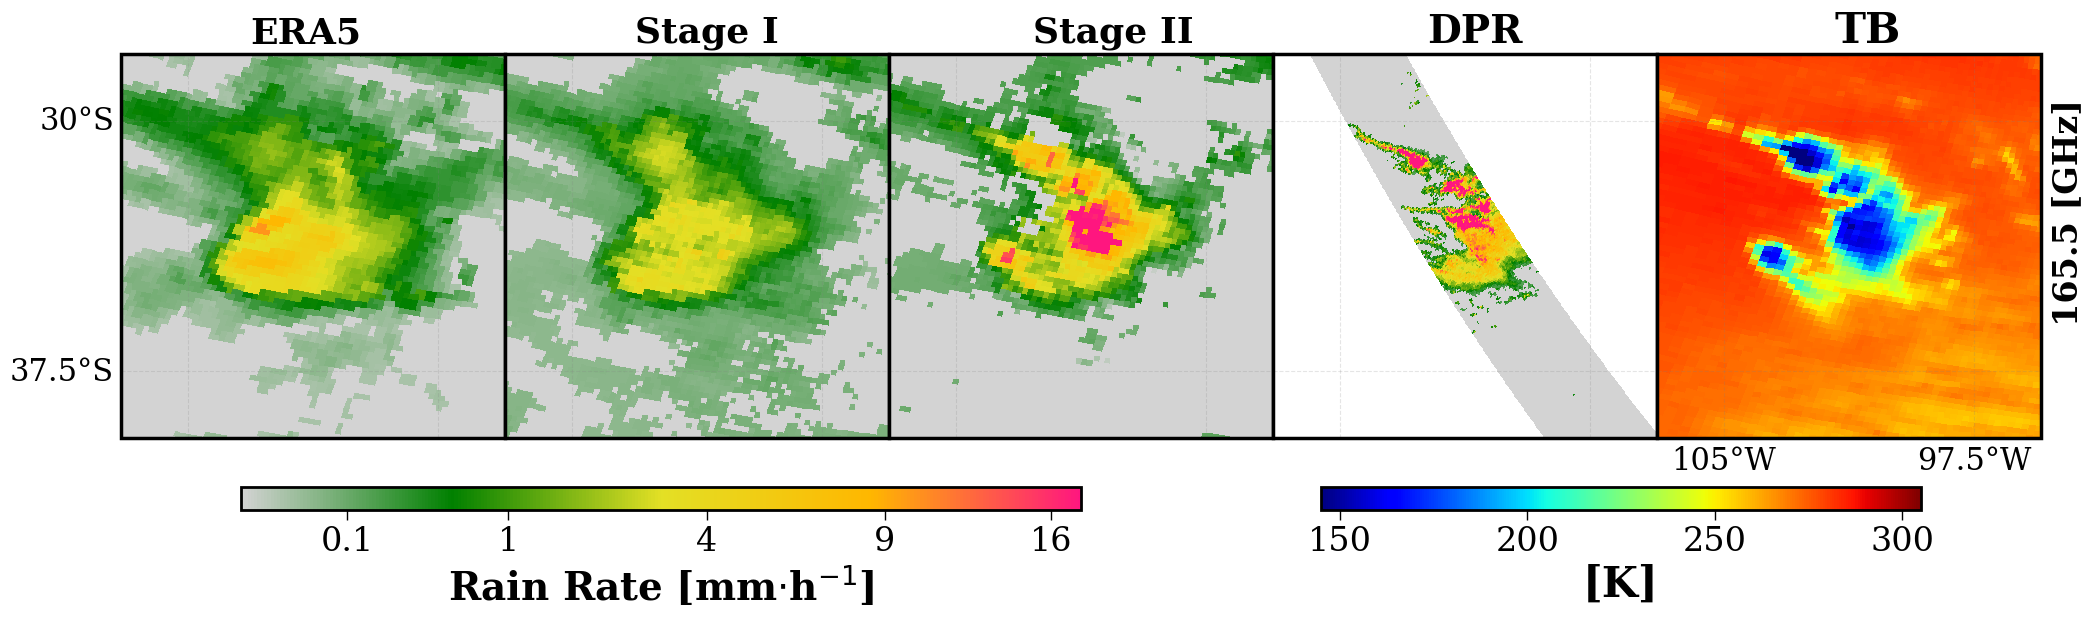

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature
from matplotlib.patches import Circle
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle

Class_Model = 'ERA5_Class.model'
Rain_Model = 'Rain_ERA5_Reg.model'
Snow_Model = 'Snow_ERA5_Reg.model'


ClassModel = xgb.Booster()
ClassModel.load_model(Class_Model)

RainModel = xgb.Booster()
RainModel.load_model(Rain_Model)

SnowModel = xgb.Booster()
SnowModel.load_model(Snow_Model)

Class_Model1 = 'CLASS.model'
Rain_Model1 = 'RAIN.model'
Snow_Model1 = 'SNOW.model'


ClassModel1 = xgb.Booster()
ClassModel1.load_model(Class_Model1)

RainModel1 = xgb.Booster()
RainModel1.load_model(Rain_Model1)

SnowModel1 = xgb.Booster()
SnowModel1.load_model(Snow_Model1)


Rain_Data = Retreival('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230315-S060744-E074913.058961.V07A.ERA5.HDF5', ClassModel, RainModel, SnowModel)
Rain_Data1 = Retreival('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230315-S060744-E074913.058961.V07A.ERA5.HDF5', ClassModel1, RainModel1, SnowModel1)

Lat_a_r = Rain_Data1[0]
Lon_a_r = Rain_Data1[1]
ERA5_Rain = Rain_Data1[-2]
Rain_XGB_ERA5 = Rain_Data[2]
Rain_XGB_Satellite = Rain_Data1[2]
Tb_Rain = h5py.File('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230315-S060744-E074913.058961.V07A.ERA5.HDF5', 'r')['/S4/Tc'][:,:,0]

Lat_a_rr = h5py.File('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230315-S060744-E074913.058961.V07A.ERA5.HDF5', 'r')['/S4/Latitude'][:]
Lon_a_rr = h5py.File('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230315-S060744-E074913.058961.V07A.ERA5.HDF5', 'r')['/S4/Longitude'][:]

DPR_data = h5py.File('Implementation_1/Orbits/'+'2A-1C.GPM-NPP.DPR-ATMS.COIN2024.20230315-S072715-E073707.051378-058961.V07A.ERA5.HDF5', 'r')
Lat_d_r = DPR_data['/Coincidence/Latitude'][:]
Lon_d_r = DPR_data['/Coincidence/Logtitude'][:]
Flag_DPR = DPR_data['DPR/SLV/phaseNearSurface'][:]
Rate_DPR = DPR_data['DPR/SLV/precipRateNearSurface'][:]
Flag_DPR = convert_precip_phase(Flag_DPR)

Rain_DPR = Rate_DPR.copy()

Rain_DPR[np.where( (Flag_DPR != 1))] = 0
Rain_DPR[np.where( (Flag_DPR == 2))] = 0


# Disable LaTeX for Colab compatibility
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 12
})

Cmap_Rain = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ['#D3D3D3', '#008000', "#E3E025", "#FFB700", "#FF167F"])
Cmap_Snow = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ["#E0E0E0",  "#A9EAFE",   "#00BFFF",   "#0000FF",  "#9400D3"])

fig = plt.figure(figsize=(24,12))

ax = np.empty(5, dtype=object)
gl = np.empty(5, dtype=object)
rect = np.empty(5, dtype=object)

ax[0] = plt.subplot2grid((1, 5), (0, 0), projection=ccrs.PlateCarree())
ax[1] = plt.subplot2grid((1, 5), (0, 1), projection=ccrs.PlateCarree())
ax[2] = plt.subplot2grid((1, 5), (0, 2), projection=ccrs.PlateCarree())
ax[3] = plt.subplot2grid((1, 5), (0, 3), projection=ccrs.PlateCarree())
ax[4] = plt.subplot2grid((1, 5), (0, 4), projection=ccrs.PlateCarree())

for i in range(5):
    for spine in ax[i].spines.values():
        spine.set_linewidth(2.5)

for i in range(0,5):
    ax[i].add_feature(cfeature.COASTLINE, linewidth=0.05)
    ax[i].add_feature(cfeature.BORDERS, linewidth=0.05, linestyle=':')
    ax[i].add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray', linestyle='-', alpha=0.8)

for i in range(0,5):
    gl[i] = ax[i].gridlines(draw_labels=True,
                        xlocs=np.arange(-180, 181, 7.5),
                        ylocs=np.arange(-90, 91, 7.5),
                        color='gray', alpha=0.2, linestyle='--')
    gl[i].right_labels = False
    gl[i].bottom_labels = False
    gl[i].top_labels = False
    gl[i].left_labels = False

####################### DPRs #############################

mask_lon = (Lon_d_r > 179.5) | (Lon_d_r < -179.5)
mask_lat = (Lat_d_r > 89.5) | (Lat_d_r < -89.5)
mask = mask_lon | mask_lat
Rain_DPR_masked = np.ma.masked_where(mask, Rain_DPR)

mesh3 = ax[3].pcolormesh(Lon_d_r, Lat_d_r, Rain_DPR_masked**0.4,
                        transform=ccrs.PlateCarree(),
                        cmap=Cmap_Rain,
                        vmin=0,
                        vmax=17.5**0.4)

####################### DPRs #############################

####################### ERA5s #############################

mask_lon = (Lon_a_r > 179.5) | (Lon_a_r < -179.5)
mask_lat = (Lat_a_r > 89.5) | (Lat_a_r < -89.5)
mask = mask_lon | mask_lat
ERA5_Rain_masked = np.ma.masked_where(mask, ERA5_Rain)

mesh0 = ax[0].pcolormesh(Lon_a_r, Lat_a_r, ERA5_Rain_masked**0.4,
                        transform=ccrs.PlateCarree(),
                        cmap=Cmap_Rain,
                        vmin=0,
                        vmax=17.5**0.4)

####################### ERA5s #############################

####################### ERA5+s #############################

mask_lon = (Lon_a_r > 179.5) | (Lon_a_r < -179.5)
mask_lat = (Lat_a_r > 89.5) | (Lat_a_r < -89.5)
mask = mask_lon | mask_lat
Rain_XGB_ERA5_masked = np.ma.masked_where(mask, Rain_XGB_ERA5)

mesh1 = ax[1].pcolormesh(Lon_a_r, Lat_a_r, Rain_XGB_ERA5_masked**0.4,
                        transform=ccrs.PlateCarree(),
                        cmap=Cmap_Rain,
                        vmin=0,
                        vmax=17.5**0.4)

####################### ERA5+s #############################

####################### Satellites #############################

mask_lon = (Lon_a_r > 179.5) | (Lon_a_r < -179.5)
mask_lat = (Lat_a_r > 89.5) | (Lat_a_r < -89.5)
mask = mask_lon | mask_lat
Rain_XGB_Satellite_masked = np.ma.masked_where(mask, Rain_XGB_Satellite)

mesh2 = ax[2].pcolormesh(Lon_a_r, Lat_a_r, Rain_XGB_Satellite_masked**0.4,
                        transform=ccrs.PlateCarree(),
                        cmap=Cmap_Rain,
                        vmin=0,
                        vmax=17.5**0.4)

####################### Satellites #############################

####################### Tbs #############################

mask_lon = (Lon_a_rr > 179.5) | (Lon_a_rr < -179.5)
mask_lat = (Lat_a_rr > 89.5) | (Lat_a_rr < -89.5)
mask = mask_lon | mask_lat
Tb_Rain_masked = np.ma.masked_where(mask, Tb_Rain)

mesh4 = ax[4].pcolormesh(Lon_a_rr, Lat_a_rr, Tb_Rain_masked,
                        transform=ccrs.PlateCarree(),
                        cmap='jet',
                        vmin=145,
                        vmax=305)

####################### Tbs #############################

gl[0].right_labels = False
gl[0].bottom_labels = False
gl[0].top_labels = False
gl[0].left_labels = True
gl[0].xlabel_style = {'size': 22}
gl[0].ylabel_style = {'size': 22}

gl[4].right_labels = False
gl[4].bottom_labels = True
gl[4].top_labels = False
gl[4].left_labels = False
gl[4].xlabel_style = {'size': 22}
gl[4].ylabel_style = {'size': 22}

regional_extent_rain = [-97.5+2, -105-2, -30+2, -37.5-2]
for i in range(0, 5):
    ax[i].set_extent(regional_extent_rain, crs=ccrs.PlateCarree())
    rect[i] = Rectangle((-92.5, 42), 3, 2, linewidth=1.6, edgecolor='black',
                        facecolor='none', transform=ccrs.PlateCarree())
    ax[i].add_patch(rect[i])
    rect[i] = Rectangle((-104.7, 20.1), 2, 3, linewidth=1.6, edgecolor='black',
                        facecolor='none', transform=ccrs.PlateCarree())
    ax[i].add_patch(rect[i])

# TB colorbar
cbar3_ax = fig.add_axes([0.6, 0.28, 0.25, 0.019])
cbar3 = fig.colorbar(mesh4, cax=cbar3_ax, orientation='horizontal')
cbar3.set_ticks(np.arange(150, 310, 50))
cbar3.set_label('[K]', fontsize=30, fontweight='bold')
cbar3.ax.tick_params(labelsize=24, length=7.5, width=1)

# Rain colorbar
cbar1_ax = fig.add_axes([0.15, 0.28, 0.35, 0.019])
cbar1 = fig.colorbar(mesh3, cax=cbar1_ax, orientation='horizontal')
rain_ticks_original = [0.1, 1, 4, 9, 16]
rain_ticks_transformed = [val**0.4 for val in rain_ticks_original]
cbar1.set_ticks(rain_ticks_transformed)
cbar1.ax.set_xticklabels(rain_ticks_original)
# Using math mode for the label with proper formatting
cbar1.set_label(r'Rain Rate [mm$\cdot$h$^{-1}$]', fontsize=28, fontweight='bold')
cbar1.ax.tick_params(labelsize=24, length=7.5, width=1)

for spine in cbar1.ax.spines.values():
    spine.set_linewidth(2)

for spine in cbar3.ax.spines.values():
    spine.set_linewidth(2)

# Text labels - using fontweight instead of \textbf
fig.text(0.154, 0.67, 'ERA5',
         fontsize=26, fontweight='bold')

fig.text(0.314, 0.67, 'Stage I',
         fontsize=26, fontweight='bold')

fig.text(0.48, 0.67, 'Stage II',
         fontsize=26, fontweight='bold')

fig.text(0.644, 0.67, 'DPR',
         fontsize=28, fontweight='bold')

fig.text(0.814, 0.67, 'TB',
         fontsize=30, fontweight='bold')

fig.text(0.904, 0.44, '165.5 [GHz]',
         fontsize=24, fontweight='bold', rotation=90)


plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0,
    hspace=-0.18
)

#plt.savefig('Fig10.png', dpi=300, bbox_inches='tight')
plt.show()


# <font color="darkblue">🌀 Orbital Retrieval Case Study: Mixed-Phase Extratropical Cyclone</font>

---

### Labrador Sea Storm — January 31, 2023

**Orbit:** ATMS #58350 &nbsp;|&nbsp; **Coincidence:** DPR #50708 &nbsp;|&nbsp; **Time Δ:** 403 sec

A mixed-phase extratropical system demonstrating TLP-R2S advantages over existing products:

| Product | Rain Structure | Snow Coverage | Swath Usage |
|:-------:|:--------------:|:-------------:|:-----------:|
| **ERA5** | Broad, smoothed | ✓ Consistent | Full |
| **GPROF** | Emission-driven | Underestimated | ~60% (loses ~1000 km) |
| **TLP-R2S** | Convective cores resolved | Variable, ERA5-consistent | **Full swath** |
| **DPR** | Reference | Limited coverage | Narrow |

> 💡 **Key finding:** TLP-R2S integrates both emission (low-freq) and scattering (high-freq) signatures, capturing convective rainfall intensity while providing full-swath retrieval—unlike GPROF which leaves ~450 km unused on each edge.

---

/tmp/ipython-input-1763724533.py:27: UserWarning: [16:58:29] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  ClassModel1.load_model(Class_Model1)
/tmp/ipython-input-1763724533.py:30: UserWarning: [16:58:29] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  RainModel1.load_model(Rain_Model1)
/tmp/ipython-input-1763724533.py:33: UserWarning: [16:58:29] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  SnowModel1.load_model(Snow_Model1)


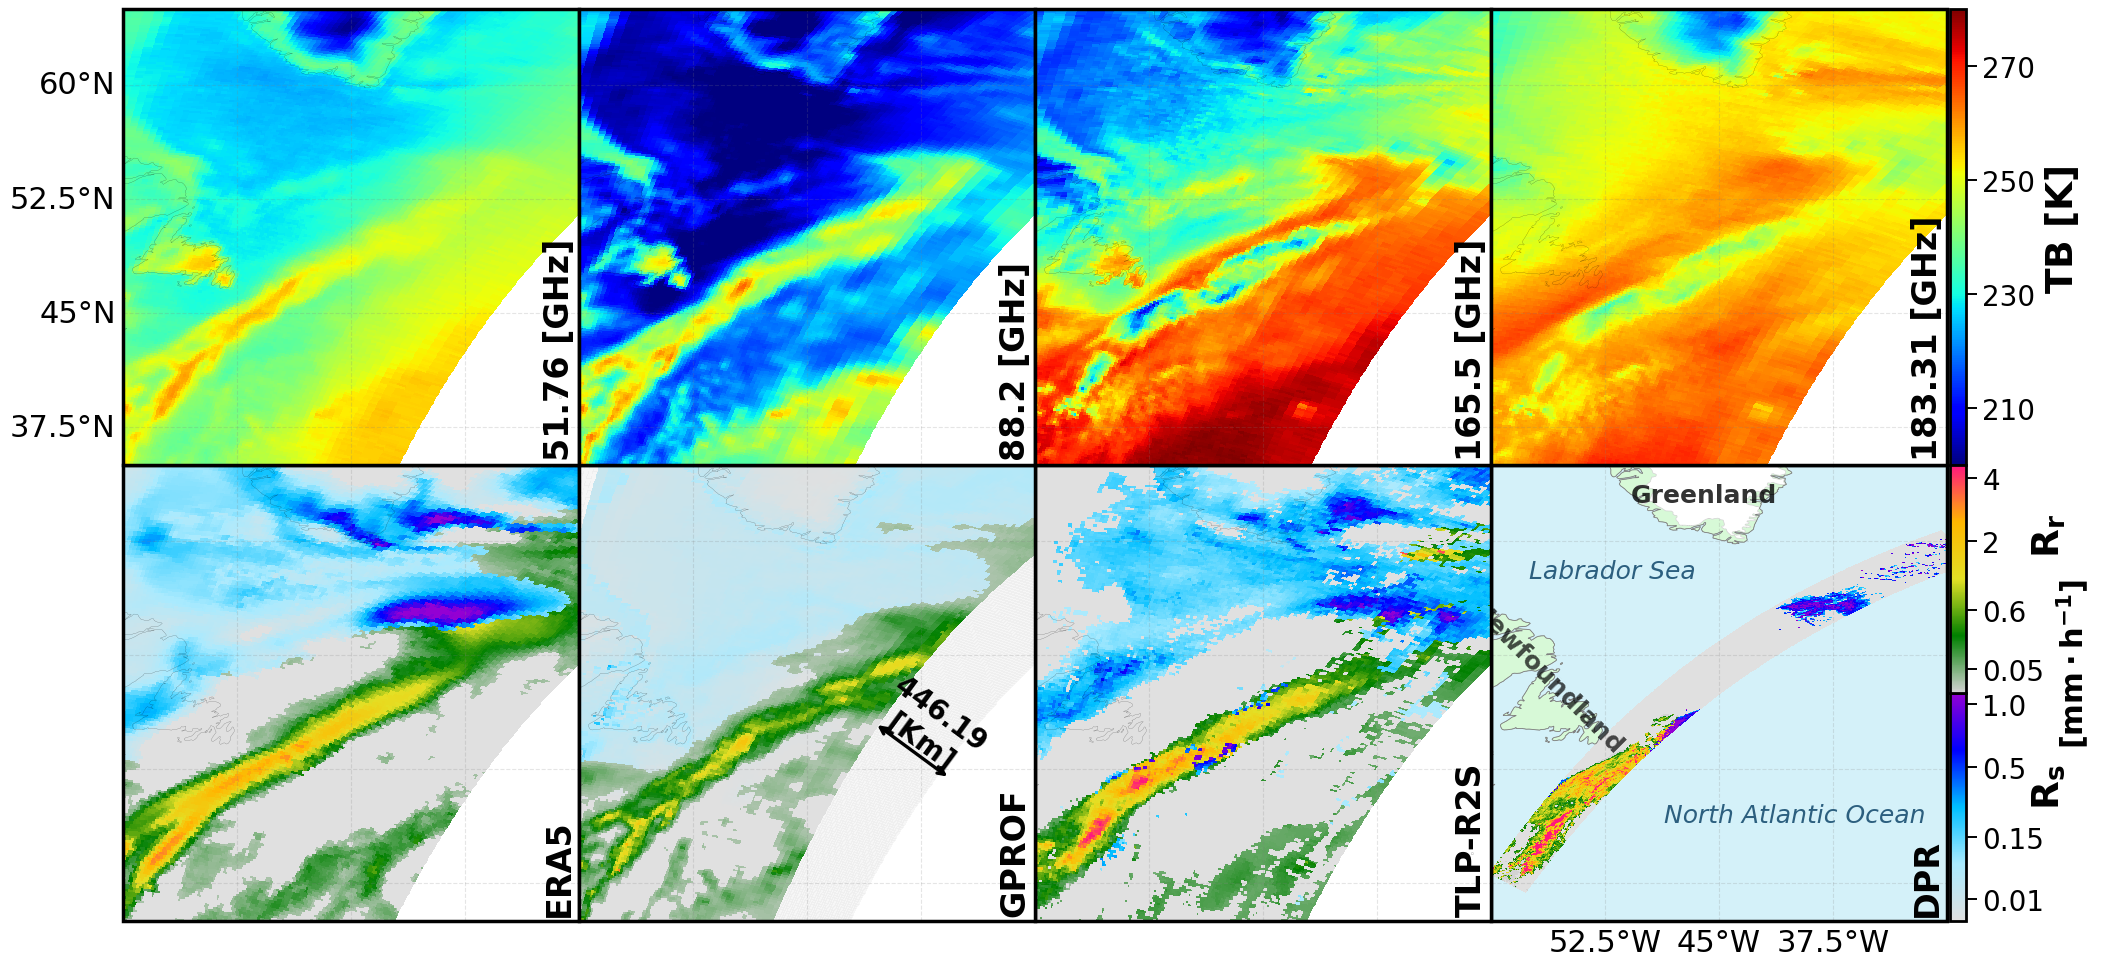

In [ ]:

ATMS_file = h5py.File('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230131-S043214-E061343.058350.V07A.ERA5.HDF5', 'r')
GPROF_file = h5py.File('Implementation_1/Orbits/'+'2A.NPP.ATMS.GPROF2021v1.20230131-S043214-E061343.058350.V07A.HDF5', 'r')
DPR_data = h5py.File('Implementation_1/Orbits/'+"2A-1C.GPM-NPP.DPR-ATMS.COIN2024.20230131-S053007-E053750.050708-058350.V07A.ERA5.HDF5", 'r')

Lat_o = ATMS_file['S1/Latitude'][:]
Lon_o = ATMS_file['S1/Longitude'][:]


Class_Model1 = 'CLASS.model'
Rain_Model1 = 'RAIN.model'
Snow_Model1 = 'SNOW.model'


ClassModel1 = xgb.Booster()
ClassModel1.load_model(Class_Model1)

RainModel1 = xgb.Booster()
RainModel1.load_model(Rain_Model1)

SnowModel1 = xgb.Booster()
SnowModel1.load_model(Snow_Model1)


Lat_a, Lon_a, Rain_ATMS, Snow_ATMS, Rain_ERA5, Snow_ERA5 = Retreival('Implementation_1/Orbits/'+'1C.NPP.ATMS.XCAL2019-V.20230131-S043214-E061343.058350.V07A.ERA5.HDF5', ClassModel1, RainModel1, SnowModel1)

Lat_d = DPR_data['/Coincidence/Latitude'][:]
Lon_d = DPR_data['/Coincidence/Logtitude'][:]
Flag_DPR = DPR_data['DPR/SLV/phaseNearSurface'][:]
Rate_DPR = DPR_data['DPR/SLV/precipRateNearSurface'][:]
Flag_DPR = convert_precip_phase(Flag_DPR)

Rain_DPR = Rate_DPR.copy()

Rain_DPR[np.where( (Flag_DPR != 1))] = 0
Rain_DPR[np.where( (Flag_DPR == 2))] = np.nan

Snow_DPR = Rate_DPR.copy()

Snow_DPR[np.where( (Flag_DPR != 2))] = 0
Snow_DPR[np.where( (Flag_DPR == 1))] = np.nan


Rain_A = Rain_ATMS.copy()

Rain_A[np.where( (Rain_ATMS == 0))] = 0
Rain_A[np.where( (Snow_ATMS > 0))] = np.nan

Snow_A = Snow_ATMS.copy()

Snow_A[np.where( (Snow_ATMS == 0))] = 0
Snow_A[np.where( (Rain_ATMS > 0))] = np.nan


Snow_E = Snow_ERA5.copy()

Snow_E[np.where( (Snow_ERA5 == 0))] = 0
Snow_E[np.where( (Rain_ERA5 > 0))] = np.nan

Rain_E = Rain_ERA5.copy()

Rain_E[np.where( (Rain_ERA5 == 0))] = 0
Rain_E[np.where( (Snow_E > 0))] = np.nan

mtpr = GPROF_file['S1/surfacePrecipitation'][:]
msr  = GPROF_file['S1/frozenPrecipitation'][:]
Lat_G = GPROF_file['S1/Latitude'][:]
Lon_G = GPROF_file['S1/Longitude'][:]

Rain_GPROF = mtpr-msr
Snow_GPROF = msr

Rain_G = Rain_GPROF.copy()

Rain_G[np.where( (Rain_GPROF <= 0))] = 0
Rain_G[np.where( (Snow_GPROF > 0.3))] = np.nan

Snow_G = Snow_GPROF.copy()

Snow_G[np.where( (Snow_GPROF <= 0))] = 0
Snow_G[np.where( (Rain_GPROF > 0.01))] = np.nan

Rain_ERA5_ = Rain_ERA5.copy()

Rain_ERA5_[np.where( (Rain_ERA5 == 0))] = 0
Rain_ERA5_[np.where( (Snow_ERA5 > 0.1) & (Rain_ERA5 < 0.01))] = np.nan

Snow_ERA5_ = Snow_ERA5.copy()

Snow_ERA5_[np.where( (Snow_ERA5 == 0))] = 0
Snow_ERA5_[np.where( (Rain_ERA5 > 0.01) & (Snow_ERA5 < 0.1))] = np.nan

mtpr = GPROF_file['S1/surfacePrecipitation'][:]
msr  = GPROF_file['S1/frozenPrecipitation'][:]

mtpr = np.where(mtpr<0, -10, mtpr)
msr = np.where(mtpr<0, -5, msr)

Rain_GGG = mtpr-msr
Snow_GGG = msr

Rain_G = interpolate_precipitation(Rain_GGG, Lat_o, Lon_o, Lat_a, Lon_a, method='nearest')
Snow_G = interpolate_precipitation(Snow_GGG, Lat_o, Lon_o, Lat_a, Lon_a, method='nearest')

Rain_GPROF = Rain_G.copy()
Rain_GPROF[np.where( (Rain_G < 0))] = np.nan
Rain_GPROF[np.where( (Rain_G == 0))] = 0
Rain_GPROF[np.where( (Snow_G > 0.3) & (Rain_G < 0.01))] = np.nan

Snow_GPROF = Snow_G.copy()
Snow_GPROF[np.where( (Snow_G < 0))] = np.nan
Snow_GPROF[np.where( (Snow_G == 0))] = 0
Snow_GPROF[np.where( (Rain_G > 0.01) & (Snow_G < 0.3))] = np.nan

Rain = [Rain_DPR, Rain_A, Rain_ERA5_, Rain_GPROF]
Snow = [Snow_DPR, Snow_A, Snow_ERA5_, Snow_GPROF]
Lat = [Lat_d, Lat_a, Lat_a, Lat_a]
Lon = [Lon_d, Lon_a, Lon_a, Lon_a]
TB = [ATMS_file['S5/Tc'][:,:,1], ATMS_file['S3/Tc'][:,:,0], ATMS_file['S4/Tc'][:,:,0], ATMS_file['S4/Tc'][:,:,2]]

# Disable LaTeX for Colab compatibility
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.size": 12
})

Cmap_Rain = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ['#D3D3D3', '#008000', "#E3E025", "#FFB700", "#FF167F"])

Cmap_Snow = plt.cm.colors.LinearSegmentedColormap.from_list('custom', ["#E0E0E0",  "#A9EAFE",   "#00BFFF",   "#0000FF",  "#9400D3"])

fig = plt.figure(figsize=(24,12))

ax = np.empty(8, dtype=object)
gl = np.empty(8, dtype=object)

ax[0] = plt.subplot2grid((2, 4), (1, 3), projection=ccrs.PlateCarree())
ax[1] = plt.subplot2grid((2, 4), (1, 2), projection=ccrs.PlateCarree())
ax[2] = plt.subplot2grid((2, 4), (1, 0), projection=ccrs.PlateCarree())
ax[3] = plt.subplot2grid((2, 4), (1, 1), projection=ccrs.PlateCarree())
ax[4] = plt.subplot2grid((2, 4), (0, 0), projection=ccrs.PlateCarree())
ax[5] = plt.subplot2grid((2, 4), (0, 1), projection=ccrs.PlateCarree())
ax[6] = plt.subplot2grid((2, 4), (0, 2), projection=ccrs.PlateCarree())
ax[7] = plt.subplot2grid((2, 4), (0, 3), projection=ccrs.PlateCarree())

for i in range(8):
    for spine in ax[i].spines.values():
        spine.set_linewidth(2.5)

regional_extent = [-60, -30, 35, 65]
for i in range(8):
    ax[i].set_extent(regional_extent, crs=ccrs.PlateCarree())
    ax[i].add_feature(cfeature.COASTLINE, linewidth=0.1)
    ax[i].add_feature(cfeature.BORDERS, linewidth=0.1, linestyle=':')

for i in range(8):
    gl[i] = ax[i].gridlines(draw_labels=True,
                        xlocs=np.arange(-180, 181, 7.5),
                        ylocs=np.arange(-90, 91, 7.5),
                        color='gray', alpha=0.2, linestyle='--')

    gl[i].xlabel_style = {'size': 22}
    gl[i].ylabel_style = {'size': 22}
    gl[i].right_labels = False
    gl[i].bottom_labels = False
    gl[i].top_labels = False
    gl[i].left_labels = False

gl[4].left_labels = True
gl[0].bottom_labels = True

for i in range(4):
    if i == 3:
        import numpy.ma as ma
        mask_lon = (Lon[i]> 179.5) | (Lon[i] < -179.5)
        mask_lat = (Lat[i] > 89.5) | (Lat[i] < -89.5)
        mask = mask_lon | mask_lat
        Rain_masked = np.ma.masked_where(mask, np.zeros_like(Rain[-1]))
        mesh1 = ax[i].pcolormesh(Lon[i], Lat[i], Rain_masked**0.5,
                            transform=ccrs.PlateCarree(),
                            cmap = Cmap_Rain,
                            vmin =0,
                            vmax =11**0.5,
                            alpha = 0.2)

    import numpy.ma as ma
    mask_lon = (Lon[i]> 179.5) | (Lon[i] < -179.5)
    mask_lat = (Lat[i] > 89.5) | (Lat[i] < -89.5)
    mask = mask_lon | mask_lat
    Rain_masked = np.ma.masked_where(mask, Rain[i])
    mesh1 = ax[i].pcolormesh(Lon[i], Lat[i], Rain_masked**0.5,
                        transform=ccrs.PlateCarree(),
                        cmap = Cmap_Rain,
                        vmin =0,
                        vmax =4.5**0.5)

    mask_lon = (Lon[i] > 179.5) | (Lon[i] < -179.5)
    mask_lat = (Lat[i] > 89.5) | (Lat[i] < -89.5)
    mask = mask_lon | mask_lat
    Snow_masked = np.ma.masked_where(mask, Snow[i])

    mesh2 = ax[i].pcolormesh(Lon[i], Lat[i], Snow_masked**0.5,
                        transform=ccrs.PlateCarree(),
                        cmap = Cmap_Snow,
                        vmin =0,
                        vmax =1.1**0.5)

for i in range(4,8):
    mask_lon = (Lon_o > 179.5) | (Lon_o < -179.5)
    mask_lat = (Lat_o > 89.5) | (Lat_o < -89.5)
    mask = mask_lon | mask_lat
    Tb_masked = np.ma.masked_where(mask, TB[i-4])
    mesh3 = ax[i].pcolormesh(Lon_o, Lat_o, Tb_masked,
                    transform=ccrs.PlateCarree(),
                    cmap = 'jet',
                    vmin =200,
                    vmax =280)

cbar3_ax = fig.add_axes([0.8812, 0.50, 0.007, 0.38])
cbar3 = fig.colorbar(mesh3, cax=cbar3_ax)
cbar3.set_ticks(np.arange(210, 280, 20))
cbar3.ax.tick_params(labelsize=20, length=8, width=1.4)

# Snow colorbar (cbar2)
cbar2_ax = fig.add_axes([0.8812, 0.120, 0.007, 0.19])
cbar2 = fig.colorbar(mesh2, cax=cbar2_ax)
snow_ticks_original = [0.01, 0.15, 0.5, 1.0]
snow_ticks_transformed = [val**0.5 for val in snow_ticks_original]
cbar2.set_ticks(snow_ticks_transformed)
cbar2.ax.set_yticklabels(snow_ticks_original)
cbar2.ax.tick_params(labelsize=20, length=8, width=1.4)

# Rain colorbar (cbar1)
cbar1_ax = fig.add_axes([0.8812, 0.31, 0.007, 0.19])
cbar1 = fig.colorbar(mesh1, cax=cbar1_ax)
rain_ticks_original = [0.05, 0.6, 2, 4]
rain_ticks_transformed = [val**0.5 for val in rain_ticks_original]
cbar1.set_ticks(rain_ticks_transformed)
cbar1.ax.set_yticklabels(rain_ticks_original)
cbar1.ax.tick_params(labelsize=20, length=8, width=1.4)

for spine in cbar1.ax.spines.values():
    spine.set_linewidth(2)

for spine in cbar2.ax.spines.values():
    spine.set_linewidth(2)

for spine in cbar3.ax.spines.values():
    spine.set_linewidth(2)

# Text labels - using fontweight instead of \textbf
fig.text(0.295, 0.13, 'ERA5',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295 + 0.19, 0.13, 'GPROF',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295 + 0.38, 0.13, 'TLP-R2S',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295 + 0.57, 0.13, 'DPR',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295, 0.13 + 0.38, '51.76 [GHz]',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295 + 0.19, 0.13 + 0.38, '88.2 [GHz]',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295 + 0.38, 0.13 + 0.38, '165.5 [GHz]',
         fontsize=24, fontweight='bold', rotation=90)

fig.text(0.295 + 0.57, 0.13 + 0.38, '183.31 [GHz]',
         fontsize=24, fontweight='bold', rotation=90)

eps = 0.025


# Using raw strings with math mode for subscripts
fig.text(0.92, 0.65, r'$\mathbf{TB\ [K]}$',
         fontsize=27, rotation=90)

fig.text(0.915, 0.22, r'$\mathbf{R_s}$',
         fontsize=27, rotation=90)

fig.text(0.915, 0.43, r'$\mathbf{R_r}$',
         fontsize=27, rotation=90)

fig.text(0.925, 0.27, r'$\mathbf{[mm \cdot h^{-1}]}$',
         fontsize=22, rotation=90)

# Arrow annotation
start = (-35.6, 44.4)
end = (-40.5, 48)

ax[3].annotate(
    '',
    xy=end,
    xytext=start,
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3]),
    arrowprops=dict(arrowstyle='<->', lw=2.4, color='black')
)

mid_x = (start[0] + end[0]) / 2
mid_y = (start[1] + end[1]) / 2

dx = end[0] - start[0]
dy = end[1] - start[1]

angle_rad = np.arctan2(dy, dx)
angle_deg = np.degrees(angle_rad)

offset_magnitude = -2
offset_x = -dy
offset_y = dx
length = np.hypot(offset_x, offset_y)
offset_x /= length
offset_y /= length

label_x = mid_x + offset_x * offset_magnitude
label_y = mid_y + offset_y * offset_magnitude

# Fixed: using math mode properly
ax[3].text(
    label_x, label_y, r'$\mathbf{446.19}$' + '\n' + r'$\mathbf{[Km]}$',
    transform=ccrs.PlateCarree(),
    rotation=angle_deg+180,
    fontsize=20,
    ha='center', va='center',
    color='black',
    rotation_mode='anchor'
)

# Features for ax[0]
ax[0].add_feature(cfeature.OCEAN, facecolor='#d4f1f9', zorder=0)
ax[0].add_feature(cfeature.LAND, facecolor="#d7f9d7", zorder=1)

glaciated = cfeature.NaturalEarthFeature(
    category='physical',
    name='glaciated_areas',
    scale='50m',
    facecolor='white',
    edgecolor='lightgray',
    linewidth=0.5
)
ax[0].add_feature(glaciated, zorder=2)
ax[0].add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='gray', zorder=3)
ax[0].add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray',
               linestyle='--', zorder=3)

ax[0].text(-46, 63, 'Greenland', transform=ccrs.PlateCarree(),
        fontsize=18, fontweight='bold', ha='center', va='center', alpha=0.8)

ax[0].text(-56.3, 51, 'Newfoundland', transform=ccrs.PlateCarree(),
        fontsize=18, fontweight='bold', ha='center', va='center', rotation=-45, alpha=0.7)

ax[0].text(-52, 58, 'Labrador Sea', transform=ccrs.PlateCarree(),
        fontsize=18, fontstyle='italic', color='#2c5f7f',
        ha='center', va='center')

ax[0].text(-40, 42, 'North Atlantic Ocean', transform=ccrs.PlateCarree(),
        fontsize=18, fontstyle='italic', color='#2c5f7f',
        ha='center', va='center')

plt.subplots_adjust(
    left=0.12,
    bottom=0.12,
    right=0.88,
    top=0.88,
    wspace=0,
    hspace=0
)

# <font color="gray">📎 Contact & Repository</font>

---

📧 **Contact:** garsh011@umn.edu

🔗 **GitHub:** [MahyarGarshasbi/TLP-R2S-ATMS](https://github.com/MahyarGarshasbi/TLP-R2S-ATMS)

---